In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns

In [2]:
df = pd.read_parquet("preprocessed.parquet")

In [3]:
df = pd.read_parquet("wbmasterf.parquet")

# **Part 2: Exploring the data**

Now that our data has been cleaned, meaningful explorations can be conducted.

## **Demographic Information**

**N by sex**:

- Overall (not taking age into account), we have an equal representation of sex. 

In [5]:
print("Total number of children:", df["child_id"].nunique())
print("Number of children by", df.groupby("sex")["child_id"].nunique())

Total number of children: 4831
Number of children by sex
Female    2329
Male      2502
Name: child_id, dtype: int64


**N by age**

- The number of samples is not evenly distributed across all age groups, and ranges from 140 to 883. Broadly speaking, we have more data available for the older age groups than the younger ones. *(*Note: age is counted in months)*

In [6]:
df.groupby("age")["child_id"].nunique()

age
16    140
17    223
18    325
19    278
20    227
21    208
22    202
23    261
24    535
25    374
26    286
27    275
28    883
29    269
30    345
Name: child_id, dtype: int64

**N by age and sex**

- The sex of the participants is distributed relatively evenly for *most* ages.

In [8]:
df.groupby(["age", "sex"])["child_id"].nunique()

age  sex   
16   Female     70
     Male       70
17   Female    111
     Male      112
18   Female    164
     Male      161
19   Female    143
     Male      135
20   Female    115
     Male      112
21   Female    100
     Male      108
22   Female    113
     Male       89
23   Female    129
     Male      132
24   Female    236
     Male      299
25   Female    179
     Male      195
26   Female    140
     Male      146
27   Female    137
     Male      138
28   Female    403
     Male      480
29   Female    128
     Male      141
30   Female    161
     Male      184
Name: child_id, dtype: int64

**Production by age**

- The bar graph below visualizes the mean value of **`production`** (number of words spoken by a child) by **`age`**. As expected, the older the child, the greater the average number of words it can produce. 1-month age differences don't seem to go hand in hand with big leaps in the value of **`production`**. Considering that we have a large number of levels for **`age`** (15 in total; the values range from 16 to 30), should we consider grouping this variable into larger intervals?

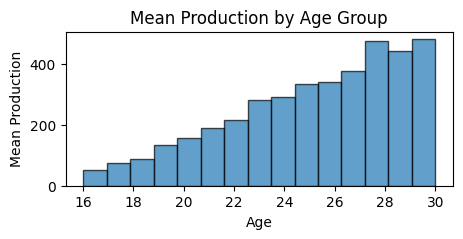

In [9]:
age_grouped = df.groupby("age")["production"].mean()

plt.figure(figsize=(5, 2))
plt.hist(age_grouped.index, bins=15, weights=age_grouped.values, edgecolor='black', alpha=0.7)

plt.xlabel("Age")
plt.ylabel("Mean Production")
plt.title("Mean Production by Age Group")
plt.show()

Run an anova to further explore the data.

In [10]:
dfa = df.groupby("child_id").agg({"sex": "first", "production": "first", "age": "first"})

In [11]:
model = ols("production ~ sex + age + sex*age", data=dfa).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                sum_sq      df            F        PR(>F)
sex       2.343337e+06     1.0    95.558438  2.312494e-22
age       9.692912e+07     1.0  3952.652318  0.000000e+00
sex:age   1.501248e+05     1.0     6.121908  1.338579e-02
Residual  1.183704e+08  4827.0          NaN           NaN


The results below show that **`sex`**, **`age`**, and **`sex-age`** interaction are all significant predictors (p<.05) of production. We conduct post-hoc tests for each predictor.

- **Sex:** Female children on average are able to produce more words than male ones.

In [12]:
tukey = pairwise_tukeyhsd(endog=dfa["production"], groups=(dfa["sex"]), alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
Female   Male -35.4437   0.0 -47.3668 -23.5205   True
-----------------------------------------------------


- **Age:** As stated before, on average, the older a child, the more words it is able to produce. Not all differences between neighbouring age groups are significant, however, indicating that it might be reasonable to group our participants in larger intervals and reduce the overall number of groups, from 15 to 5, for example.

In [13]:
tukey = pairwise_tukeyhsd(endog=dfa["production"], groups=(dfa["age"]), alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    16     17  20.0217 0.9977 -37.3567  77.4002  False
    16     18  34.5695 0.6791 -19.2244  88.3633  False
    16     19  79.9118 0.0001  24.7659 135.0578   True
    16     20 103.6558    0.0  46.4727  160.839   True
    16     21 136.5745    0.0  78.4036 194.7454   True
    16     22 163.6284    0.0  105.111 222.1459   True
    16     23 228.9027    0.0 173.1585 284.6469   True
    16     24 238.5104    0.0 187.9951 289.0257   True
    16     25 281.5138    0.0 228.7916  334.236   True
    16     26 289.0823    0.0 234.1953 343.9693   True
    16     27 325.9644    0.0 270.7178  381.211   True
    16     28 423.5148    0.0 375.1081 471.9215   True
    16     29 392.1438    0.0 336.6897 447.5978   True
    16     30 430.2615    0.0 376.9392 483.5838   True
    17     18  14.5477 0.9993 -31.7232  60.8186  False
    17    

- **Sex*Age:** However, we know that genders are not equally distributed across all age groups, so the effects found for sex might be driven by age differences and/or vice-versa. **Optional:** run a post-hoc on the interaction term as well just to check, but the large amount of levels of **`age`** make this tedious.

In [13]:
#dfa["interaction"] = dfa["age"].astype(str) + '_' + dfa["sex"].astype(str)
#tukey = pairwise_tukeyhsd(endog=dfa["production"], groups=dfa["interaction"], alpha=0.05)
#print(tukey)

**Conclusion:** We ultimately decide to group **`age`** into 5 groups, each spanning an interval of 3 months. Working with 15 different levels is not feasible, and the differences that 1 to 2 months make are not meaningful enough to justify keeping our data overly complicated and having very small sample sizes for certain **`age`** x **`sex`** combinations (i.e. n = 70 for 16-month-olds of either sex).

In [14]:
agebins = [16, 19, 22, 25, 28, 31]
agelabels = ["1", "2", "3", "4", "5"]
df["ageg"] = pd.cut(df["age"], bins=agebins, labels=agelabels, right=False)

## Regrouped data

This is what our data looks like now. Each group has at least n = 343 (instead of 70):

In [15]:
df.groupby(["ageg", "sex"])["child_id"].nunique()

ageg  sex   
1     Female    345
      Male      343
2     Female    358
      Male      355
3     Female    478
      Male      520
4     Female    456
      Male      479
5     Female    692
      Male      805
Name: child_id, dtype: int64

**Mean number of items able to speak by age group and sex**:

/var/folders/2t/bxnv0_3d77b_2_myz6gmdr5m0000gn/T/ipykernel_24675/1703845227.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=dfpl, x='ageg', y='production', hue='sex', ci=None, palette={'Male': 'b', 'Female': 'r'})


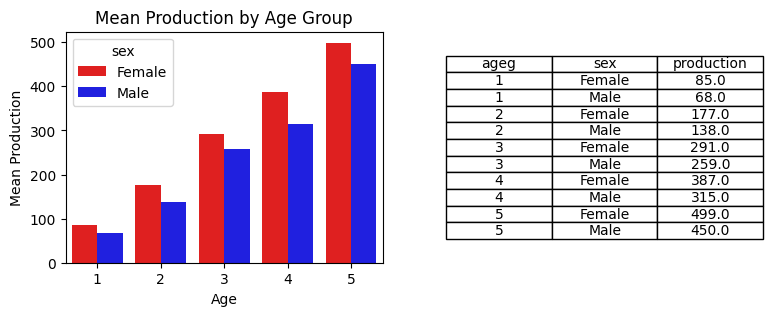

In [16]:
dfpl = df.groupby(["ageg", "sex"])["production"].mean().round().reset_index()
plt.figure(figsize=(9, 3))
plt.subplot(1, 2, 1)
sns.barplot(data=dfpl, x='ageg', y='production', hue='sex', ci=None, palette={'Male': 'b', 'Female': 'r'})
plt.xlabel("Age")
plt.ylabel("Mean Production")
plt.title("Mean Production by Age Group")

plt.subplot(1, 2, 2)
plt.axis('off')  # Turn off axis
plt.table(cellText=dfpl.values, colLabels=dfpl.columns, cellLoc='center', loc='center')
plt.show()

By regrouping age into 3-month intervals, the differences in total vocabulary size by age are made more meaningful and distinct. For each `age group`, the mean for male children is lower than that of the female children.

## **Categories**

Each of our 680 items has been assigned to a **`category`**. In total, there are 22 word categories. The number of items in each category ranges from 6 to 103.

Our idea is for our application to assess the user's (i.e., child's) current vocabulary as best as possible, and to then leverage this information to tailor recommendations to our user. Not all 680 items will be able to be included in the assessment, so we need a logic to determine how we select assessment words. For one, it is clear that certain words will not be appropriate assessment words for certain age groups (i.e. `baa baa` for a 30-month-old, or `refrigerator` for a 16-month-old), so the chosen words should differ depending on the user's given age.

**But:** Should we do the same for sex?

The analyses conducted above have shown that female children tend to have overall larger vocabularies than male ones, but they have not provided clarity on how the *quality* i.e. **`category`** of words differ between sex.

Idea: Investigate the top 5 word categories by **`sex`** and also **`ageg`** (age group).

Calculate the average percentage of words that children are able to produce by **`category`**, **`ageg`** and **`sex`**.

In [17]:
dftest = df.groupby(["ageg", "category", "sex"])["value"].mean().reset_index()
dftest["value"] = dftest["value"]*100

Find the 5 categories with the largest percentages for each **`ageg`** x **`sex`** combination.

In [18]:
dftry = dftest.groupby(["ageg", "sex"])["value"].nlargest().reset_index()
dftry = dftry.drop(columns = ["level_2"])
result_df = pd.merge(dftry, dftest, on=["ageg", "sex", "value"], how="inner")
result_df

,ageg,sex,value,category
0,1,Female,50.676329,sounds
1,1,Female,30.388406,games_routines
2,1,Female,22.769726,body_parts
3,1,Female,21.755233,toys
4,1,Female,19.870065,people
5,1,Male,45.796890,sounds
6,1,Male,24.991254,games_routines
7,1,Male,17.284465,vehicles
8,1,Male,16.929728,people
9,1,Male,16.909621,toys


Extra: Top items by **`ageg`** x **`sex`**

In [27]:
dftest2 = df.groupby(["ageg", "item_definition", "sex"])["value"].mean().reset_index()
dftest2["value"] = dftest2["value"]*100
dftry = dftest2.groupby(["ageg", "sex"])["value"].nlargest().reset_index()
dftry = dftry.drop(columns = ["level_2"])
result_df = pd.merge(dftry, dftest2, on=["ageg", "sex", "value"], how="inner")
result_df.head(10)

,ageg,sex,value,item_definition
0,1,Female,94.202899,daddy*
1,1,Female,93.623188,mommy*
2,1,Female,83.478261,ball
3,1,Female,83.188406,bye
4,1,Female,80.579710,hi
5,1,Male,92.128280,mommy*
6,1,Male,89.795918,daddy*
7,1,Male,76.676385,ball
8,1,Male,74.635569,uh oh
9,1,Male,73.177843,bye


**Summary:**

- `Sounds` is the top mastered category regardless of age group and sex
- `Mommy` and `daddy` are always the top 2 mastered words for every possible group
- Female children have higher percentages than age-matched male counterpants for shared categories
- Female children have larger vocabularies than males
- Female and male children differ slightly in which categories of words they prioritize (e.g. vehicles for males, body parts/animals for females), but this observation is heavily dependent on age as well. But their respective vocabularies are probably also distinct in their *quality* in addition to quantity.

There are still other parameters concerning the assessment questionnaire that have to be decided on, so no items will be selected yet. 

Save new **`df`** with recoded age information.

In [22]:
df.to_parquet("wbmasterf.parquet")

***

**Extra, data viz*

- 100% stacked bar chart, proportions of total vocab occupied by each category (keep in mind not all categories have same # of items)

<Figure size 1000x600 with 0 Axes>

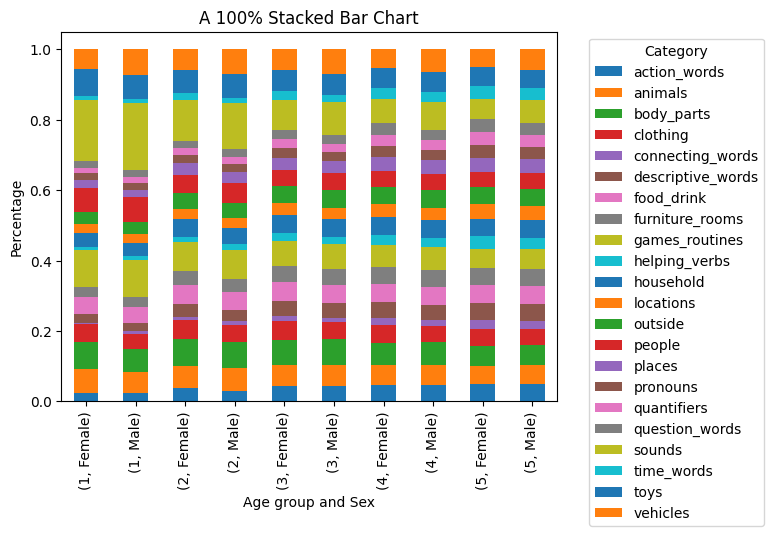

In [35]:
#check this again!
plt.figure(figsize=(10, 6))
pd.crosstab([dftest["ageg"], dftest["sex"]], dftest["category"], values=dftest["value"],  aggfunc="sum", normalize="index").plot(kind="bar", stacked=True)
plt.xlabel("Age group and Sex")
plt.ylabel("Percentage")
plt.title("A 100% Stacked Bar Chart")
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

- Faceted bar plot

In [29]:
nmean = df.groupby(["ageg", "category"])["value"].mean()
#reformat
nmean = nmean.reset_index()
nmean.rename(columns = {0:"value"}, inplace = True)

/Users/sonia/anaconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


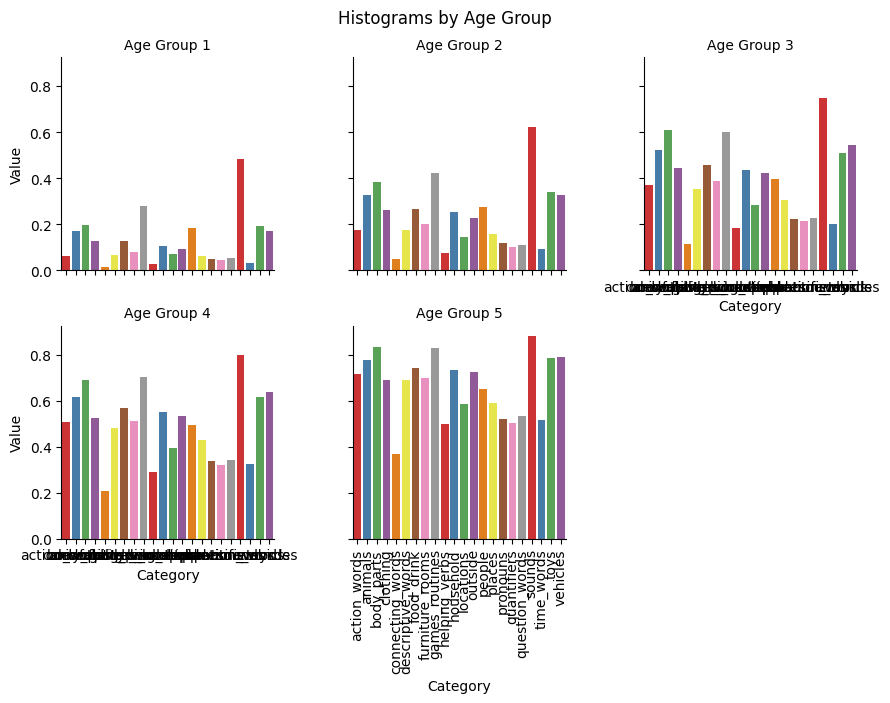

In [30]:
g = sns.FacetGrid(nmean, col="ageg", col_wrap=3, height=3)
g.map(sns.barplot, "category", "value", palette="Set1")

g.set_axis_labels("Category", "Value")
g.set_titles("Age Group {col_name}")

plt.subplots_adjust(top=0.9)
plt.xticks(rotation=90)

g.fig.suptitle("Histograms by Age Group")

plt.show()